# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split, GridSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from scipy.signal import find_peaks 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

/Users/eseyram/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
try:
    taxi_df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')
except:
    taxi_df = pd.read_csv('/datasets/taxi.csv')

In [3]:
def get_info(df):
    print('Head:')
    display(df.head())
    print('--END--')
    print('Info:')
    display(df.info())
    print('--END--')
    print('Missing values:')
    display(df.isnull().sum()/df.shape[0])
    print('--END--')
    print('Duplicates:')
    display(df.duplicated().sum())
    print('--END--')
    print('Describe:')
    display(df.describe())
get_info(taxi_df)  

Head:


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


--END--
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

--END--
Missing values:


datetime      0.0
num_orders    0.0
dtype: float64

--END--
Duplicates:


0

--END--
Describe:


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


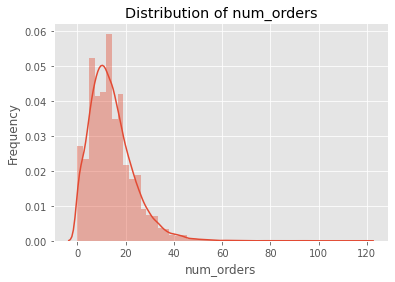

In [4]:
sn.distplot(taxi_df['num_orders'])
plt.title('Distribution of num_orders')
plt.ylabel('Frequency');

In [5]:
taxi_df['datetime'] = pd.to_datetime(taxi_df['datetime'])
taxi_df = taxi_df.set_index('datetime')
taxi_df.index.is_monotonic

True

# Conclusion

There are no missing or null or duplicated values in the dataset. Number of taxi orders column is right skewed with some outliers. 
The datetime column which was string value have been converted to the datetime fomart and column Subsequently  made the index.

## Analysis

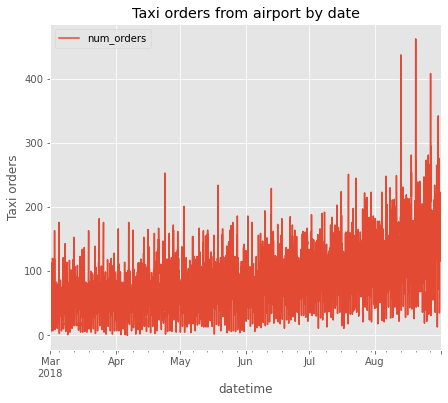

In [6]:
taxi_df.resample('1H').sum().plot(figsize = (7,6),title= 'Taxi orders from airport by date')
plt.ylabel('Taxi orders');

In [7]:
taxi_df = taxi_df.resample('1H').sum()

<Figure size 720x432 with 0 Axes>

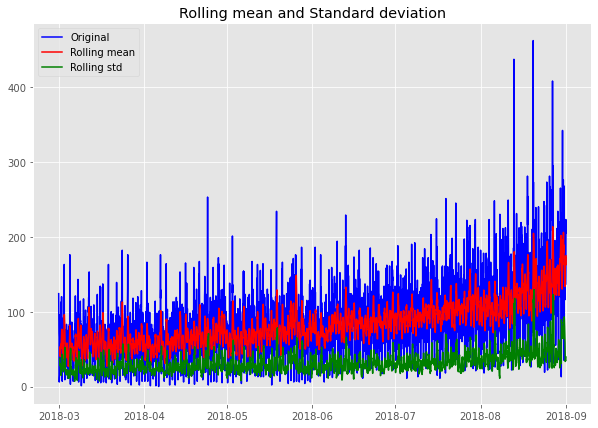

In [8]:
def test_stationarity(df):
    """
        Takes dataframe and test for stationarity.
        Compute the rolling mean for 10 days
        compute the rolling standard deviation for 10days
    """
    plt.figure(figsize=(10,6))
    rolmean = df['num_orders'].rolling(10).mean()
    rolstd = df['num_orders'].rolling(10).std()
    plt.figure(figsize=(10,7))
    org = plt.plot(df, color = 'blue',label='Original')
    mean = plt.plot(rolmean, color='red', label = 'Rolling mean')
    std = plt.plot(rolstd, color = 'green', label = 'Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling mean and Standard deviation')
    plt.show(block=False)
    
test_stationarity(taxi_df);

The rolling mean of the data rises/varies over time indicating an increasing trend in the data.

**Augmented Dickey Fuller Test**

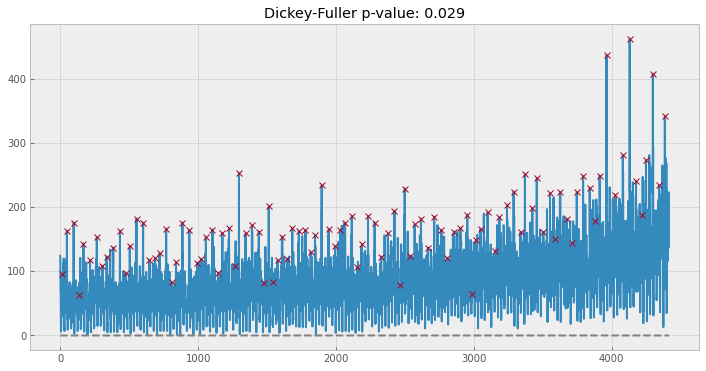

In [9]:
with plt.style.context('bmh'):  
    x = taxi_df['num_orders'].values
    peaks, _ = find_peaks(x, distance=30)
    plt.figure(figsize=(12, 6))
    plt.plot(x, label='Days')
    plt.plot(peaks, x[peaks], "x")
    plt.plot(np.zeros_like(x), "--", color="gray")
    plt.title("Dickey-Fuller p-value: {}".format(round(sm.tsa.stattools.adfuller(
        taxi_df['num_orders'].values)[1], 3)))  
    plt.grid(True) 

In [10]:
def adfuller_stats(values):
    df_test = sm.tsa.stattools.adfuller(values)
    df_output = pd.Series(df_test[0:4], 
                          index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in df_test[4].items():
        df_output['Critical Value (%s)'%key] = value
    return df_output
adfuller_stats(taxi_df['num_orders'].values)

Test Statistic                   -3.068924
p-value                           0.028940
#Lags Used                       30.000000
Number of Observations Used    4385.000000
Critical Value (1%)              -3.431842
Critical Value (5%)              -2.862199
Critical Value (10%)             -2.567121
dtype: float64

Assuming an $\alpha$ value of 1, the p-value is less that 0.05 which indicates that, the data is stationary.

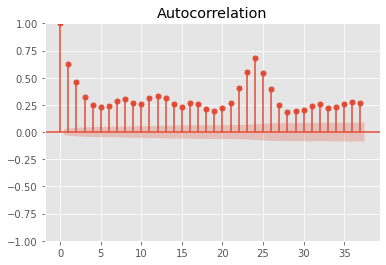

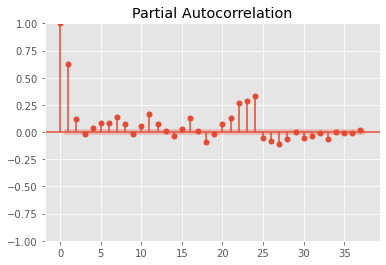

In [11]:
plot_acf(taxi_df)
plot_pacf(taxi_df)
plt.show()

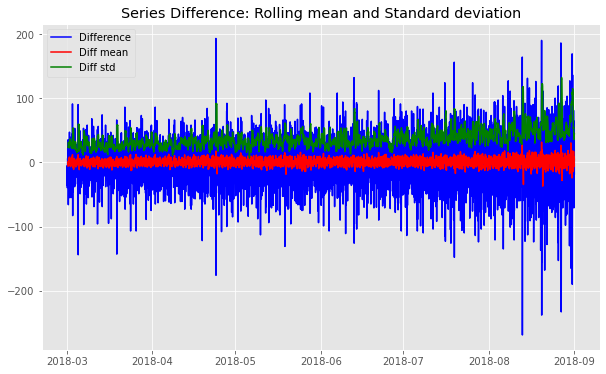

In [12]:
def data_difference(df):
    """
        Takes the dataframe and plots results after analysis
        taxi_diff: computes the series difference
        diff_mean: computes the rolling mean of series difference
        diff_std: computes the rooling std of series difference
    """
    plt.figure(figsize=(10,6))
    taxi_diff = taxi_df.diff(periods=1)
    diff_mean = taxi_diff.rolling(10).mean()
    diff_std = taxi_diff.rolling(10).std()
    
    org = plt.plot(taxi_diff, color = 'blue',label='Difference')
    mean = plt.plot(diff_mean, color='red', label = 'Diff mean')
    std = plt.plot(diff_std, color = 'green', label = 'Diff std')
    
    plt.legend(loc='best')
    plt.title('Series Difference: Rolling mean and Standard deviation')
    plt.show(block=False)
data_difference(taxi_df)

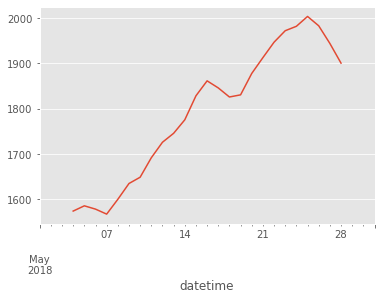

In [13]:
# one day sample to ascertain trend in data
(seasonal_decompose(taxi_df['2018-05-01':'2018-05-31']
                    .resample('1D').sum().loc[:,'num_orders']).trend.plot());

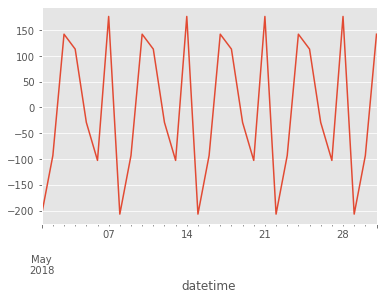

In [14]:
# one day plot for seasonality in data
(seasonal_decompose(taxi_df['2018-05-01':'2018-05-31']
                    .resample('1D').sum().loc[:,'num_orders']).seasonal.plot());

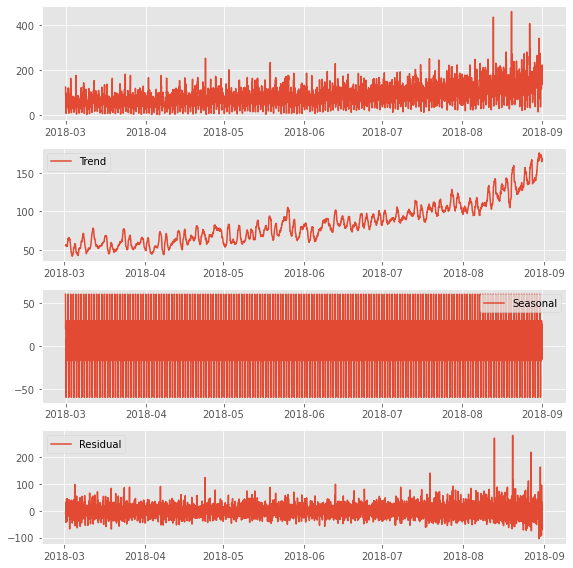

In [15]:
def decomposed_plot(taxi_df):
    """
        Takes dataframe and plots results after analysis
        decomposition: data is decomposed 
        trend: captures the trend in the data
        seasonal: captures the seasonal variations in data
        residual: captures the residual in the data
    """
    decomposition = seasonal_decompose(taxi_df)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    plt.figure(figsize=(8,8))
    plt.subplot(411)
    plt.plot(taxi_df,label='Original')
    plt.subplot(412)
    plt.plot(trend,label = 'Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonal')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residual')
    plt.legend(loc='best')
    plt.tight_layout()
decomposed_plot(taxi_df)

The decomposition of the data shows a repeating pattern in seasonality and an increase in trend over time. 

In [16]:
def create_features(df, max_lag,rolling_mean_size):
    """
        Takes the dataframe, number of lagging, 
        and number rolling and returns a new dataframe 
        New features are creatured for year, month, day, dayofmonth, hour, weekend
    """
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['dayofmonth'] = df.index.day
    df['hour'] = df.index.hour
    df['is_weekend'] = df.dayofweek.isin([5,6])*1
    
    for lag in range(1, max_lag +1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df
create_features(taxi_df, 6,10)

,num_orders,year,month,day,dayofweek,dayofmonth,hour,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,1,1,0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,1,2,0,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,1,3,0,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,1,4,0,66.0,71.0,85.0,124.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,31,19,0,207.0,217.0,197.0,116.0,133.0,166.0,173.3
2018-08-31 20:00:00,154,2018,8,31,4,31,20,0,136.0,207.0,217.0,197.0,116.0,133.0,166.6
2018-08-31 21:00:00,159,2018,8,31,4,31,21,0,154.0,136.0,207.0,217.0,197.0,116.0,162.9


In [17]:
train,test = train_test_split(taxi_df,shuffle = False, test_size = .1)
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [18]:
train = train.dropna()
features_train = train.drop('num_orders',axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders',axis=1)
target_test = test['num_orders']

# Conclusion

The results shows an increasing trend and seasonality in the data. In order to build and trian the model, additional features were created from the datetime coulmn to capture the variations in the data.

In [19]:
def plotModelResults(model, X_train, X_test, y_train, y_test, plot_anomalies=False):
    """ Compute the predicted values.
        Compute the RMSE from the predicted and true values.
        Plot both predicted and true values. 
    """
    prediction = model.predict(X_test)
    plt.figure(figsize=(12, 6))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
        
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(y_test))
        anomalies[y_test<lower] = y_test[y_test<lower]
        anomalies[y_test>upper] = y_test[y_test>upper]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    rmse = mean_squared_error(prediction, y_test)**0.5
    plt.title(f" RMSE {rmse:.2f}")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)

In [20]:
def print_results(y_train, y_test, predict_train,predict_test):
    """Prints Root Mean squared Error and Mean Absolute Errors results of the models.
    """
    print('MAE for train data:',mean_absolute_error(y_train,predict_train ))
    print('MAE for test data:',mean_absolute_error(y_test,predict_test))
    print('RMSE for train data:', mean_squared_error(y_train,predict_train)**0.5)
    print('RMSE for train data:', mean_squared_error(y_test,predict_test)**0.5)

## Training & Testing

MAE for train data: 23.406770364489315
MAE for test data: 40.266346781232556
RMSE for train data: 30.472185269351137
RMSE for train data: 53.0911746453739


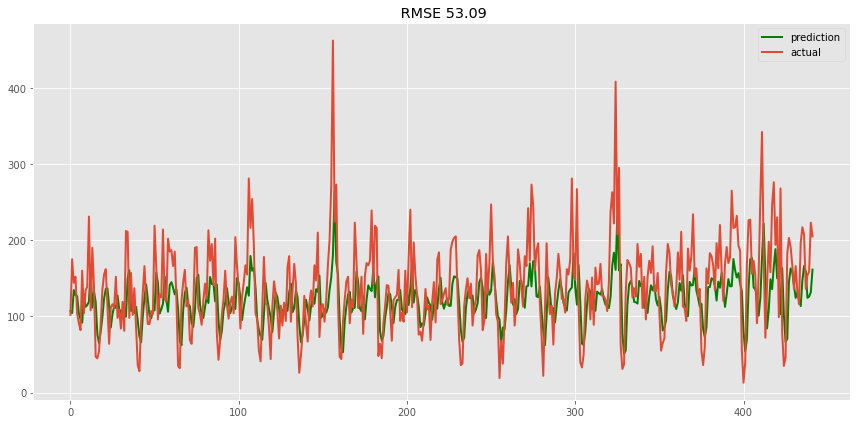

In [21]:
def linear_Regression(x_train, x_test, y_train, y_test):
    """
        Takes the training and test dataset
        Scales the data
        Using Linear Regression, the data is trained and predictions made using  
         for both test and training set for their MAE and RMSE
    """
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    lr = LinearRegression().fit(x_train, y_train)
    predict_test = lr.predict(x_test)
    predict_train = lr.predict(x_train)
    results = print_results(y_train, y_test, predict_train,predict_test)
    plotModelResults(lr, x_train, x_test, y_train, y_test) 
linear_Regression(features_train, features_test, target_train, target_test)


MAE for train data: 17.92370206004796
MAE for test data: 39.53623888187096
RMSE for train data: 23.57682473201688
RMSE for train data: 53.047521685613866


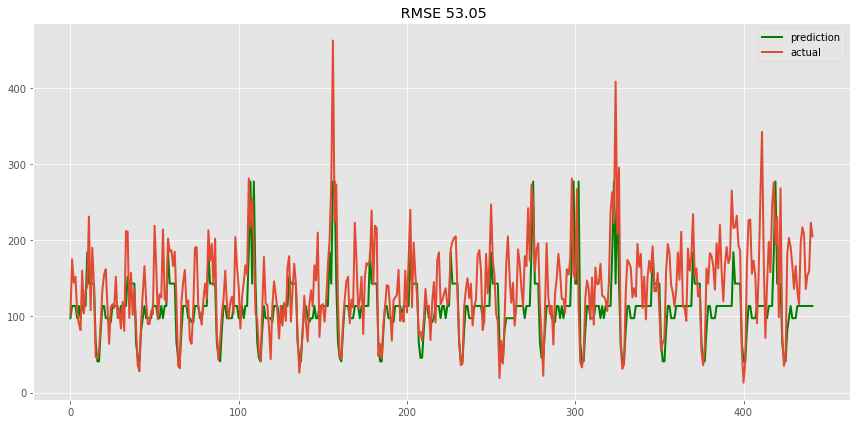

In [22]:
def Decision_tree_reg(x_train, x_test, y_train, y_test):
    """
        Takes the training and test dataset
        Using Decision Tree Regression, the data is 
            trained and predictions made using for both 
            test and training set for their MAE and RMSE
    """
    params = {'min_samples_split': range(2,20,2),
             'max_depth': range(2,8,2)}
    tscv = TimeSeriesSplit(n_splits=5)
    grid = GridSearchCV(DecisionTreeRegressor(random_state=123),
                       params, scoring='neg_root_mean_squared_error',
                        cv=tscv, refit=True)
    grid.fit(x_train,y_train)
    dtr = DecisionTreeRegressor(**grid.best_params_).fit(x_train,y_train)
    predict_test = dtr.predict(x_test)
    predict_train = dtr.predict(x_train)
    results = print_results(y_train, y_test, predict_train,predict_test)
    plotModelResults(dtr, x_train, x_test, y_train, y_test)
Decision_tree_reg(features_train, features_test, target_train, target_test)

MAE for train data: 11.281039542394632
MAE for test data: 35.351393904934866
RMSE for train data: 15.005283134878074
RMSE for train data: 46.93640232310618


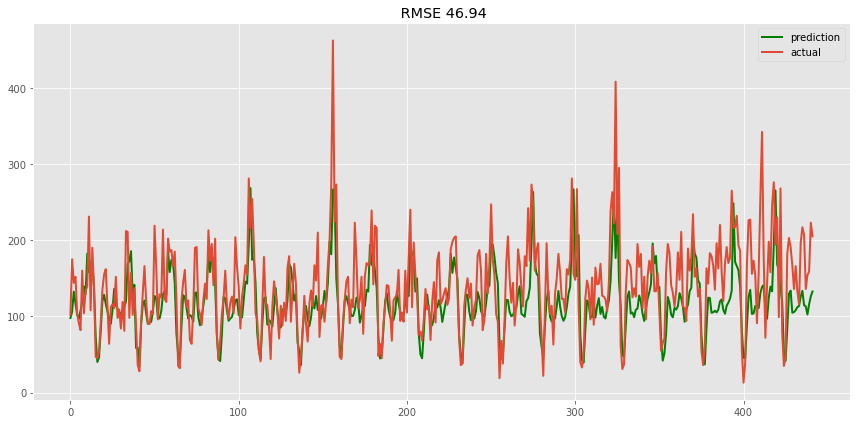

In [23]:
def RandomforestReg(x_train, x_test, y_train, y_test):
    """
        Takes the training and test dataset
        Using RandomForest Regression, the data is 
            trained and predictions made using for both 
            test and training set for their MAE and RMSE
    """
    params = {'min_samples_split': range(10, 40, 10), 
              'max_depth': range(4,16,4), 
              'n_estimators':range(50,60,5),
              'max_features':range(3,10,2)}
    tscv = TimeSeriesSplit(n_splits=5)
    grid = GridSearchCV(RandomForestRegressor(),
                        param_grid=params,scoring='neg_root_mean_squared_error', 
                        cv=tscv,n_jobs=5)
    grid.fit(x_train, y_train)
    rfr = RandomForestRegressor(**grid.best_params_).fit(x_train, y_train)
    predict_test = rfr.predict(x_test)
    predict_train = rfr.predict(x_train)
    results = print_results(y_train, y_test, predict_train,predict_test)
    plotModelResults(rfr, x_train, x_test, y_train, y_test)
RandomforestReg(features_train, features_test, target_train, target_test)

[0]	validation_0-rmse:140.76677
[1]	validation_0-rmse:131.10118
[2]	validation_0-rmse:123.23317
[3]	validation_0-rmse:115.95130
[4]	validation_0-rmse:109.50392
[5]	validation_0-rmse:103.83951
[6]	validation_0-rmse:98.05090
[7]	validation_0-rmse:93.44669
[8]	validation_0-rmse:88.93044
[9]	validation_0-rmse:85.38846
[10]	validation_0-rmse:81.60047
[11]	validation_0-rmse:78.14400
[12]	validation_0-rmse:75.15448
[13]	validation_0-rmse:72.73439
[14]	validation_0-rmse:69.95271
[15]	validation_0-rmse:67.99756
[16]	validation_0-rmse:65.99821
[17]	validation_0-rmse:64.51594
[18]	validation_0-rmse:63.04548
[19]	validation_0-rmse:61.63304
[20]	validation_0-rmse:60.47179
[21]	validation_0-rmse:59.39037
[22]	validation_0-rmse:58.20860
[23]	validation_0-rmse:57.47421
[24]	validation_0-rmse:56.68442
[25]	validation_0-rmse:55.80065
[26]	validation_0-rmse:54.98338
[27]	validation_0-rmse:54.33697
[28]	validation_0-rmse:53.82877
[29]	validation_0-rmse:53.09298
[30]	validation_0-rmse:52.33572
[31]	validat

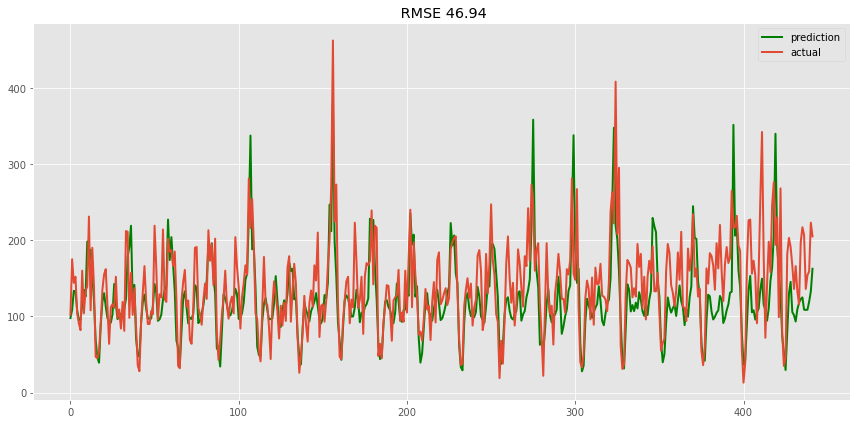

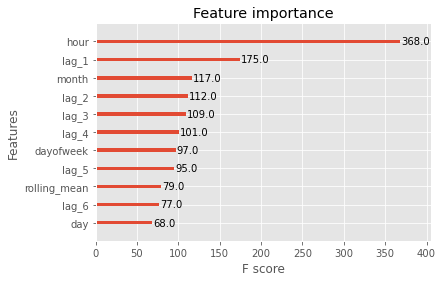

In [24]:
def xgboost(x_train, x_test,y_train, y_test):
    """
        Takes the training and test datasets and returns the MAE and RMSE.
        Params: set of parameters to train with 
        grid: Searches through the params and selects the best option
        XGBRegressor is used to train and predict the model
    """
    params = {'max_depth': [4,8],
              'objective':['reg:squarederror'],
              'learning_rate':[0.1]}
    tscv = TimeSeriesSplit(n_splits=5)
    grid = GridSearchCV(XGBRegressor(random_state=123),
                        param_grid=params,
                        scoring='neg_root_mean_squared_error', cv=tscv)
    grid.fit(x_train, y_train)
    xgbr = XGBRegressor(**grid.best_params_)
    xgbr.fit(x_train,y_train,eval_set=[(x_test,y_test)], eval_metric='rmse')
    predict_test = xgbr.predict(x_test)
    predict_train = xgbr.predict(x_train)
    results = print_results(y_train, y_test, predict_train,predict_test)
    plotModelResults(xgbr, x_train, x_test, y_train, y_test)
    plot_importance(xgbr);
xgboost(features_train, features_test, target_train, target_test)

MAE for train data: 11.504206304710374
MAE for test data: 32.00135855338842
RMSE for train data: 15.191170587628548
RMSE for train data: 43.24963893954397


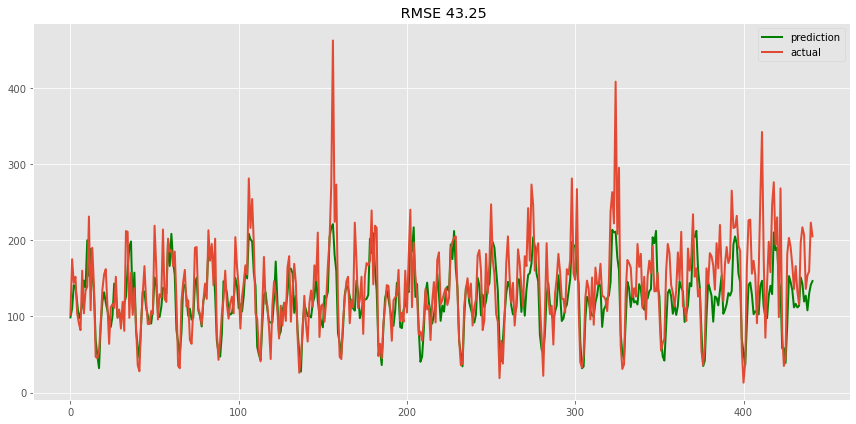

In [25]:
def Lightgbmreg(x_train,x_test,y_train,y_test):
    """
        Takes the training and test datasets and returns the MAE and RMSE.
        Params: set of parameters to train with 
        grid: Searches through the params and selects the best option
        LGBMRegressor is used to train and predict the model
    """
    params = {'learning_rate': [0.1],
              'max_depth': [6,8],
              }
    tscv = TimeSeriesSplit(n_splits=5)
    g_cv = GridSearchCV(LGBMRegressor(random_state=123),
                        scoring='neg_root_mean_squared_error',
                        param_grid=params, cv=tscv)
    g_cv.fit(x_train, y_train)
    lgbm = LGBMRegressor(**g_cv.best_params_)
    lgbm.fit(x_train,y_train,verbose=1)           
    predict_test = lgbm.predict(x_test)
    predict_train = lgbm.predict(x_train)
    results = print_results(y_train, y_test, predict_train,predict_test)
    plotModelResults(lgbm, x_train, x_test, y_train, y_test)
Lightgbmreg(features_train, features_test, target_train, target_test)

# Model Results
||Model|MAE Train|MAE Test|RMSE Train|RMSE Test|
|--|--|--|--|--|--|
|1|Linear Regression|23.40|40.26|30.47|53.09|
|2|Decision Tree Reg|17.92|39.53|23.57|53.04|
|3|RandomForest Reg|11.33|35.31|15.31|46.50|
|4|XGBoost|14.04|35.24|18.25|46.94|
|5|Light GBM|11.50|32.00|15.19|43.24|


Previous analysis showed that, the data was not stationary subsequently the model was trained uing different models. The best results on RMSE test set came from **RandomForest 46.50, XGBoost  46.94 and LightGBM 43.24.**